# Experiment 2: What persists, exists

> Conducting the second experiment that is training the cellular automaton to maintain its form after it has reached the desired shape.

In [115]:
#| default_exp what_persists_exists

In [116]:
#| hide
# from nbdev.showdoc import *

In [117]:
#| export
# import NeuralCellularAutomata_PyTorch.custom_attention
from NeuralCellularAutomata_PyTorch.core import *
# from NeuralCellularAutomata_PyTorch.core import COLOR_N
from NeuralCellularAutomata_PyTorch.learning_to_grow import *

# from NeuralCellularAutomata_PyTorch.core import CHANNEL_N, load_image, TARGET_SIZE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial

In [118]:
batch_size = 1
# n_epochs = 200
CHANNEL_N = 16
COLOR_N = 3


core_diameter = 8

In [119]:
path = '../images/emoji_u1f98e.png'
# path = '../images/bw.png'

In [120]:
# dna = torch.rand([CHANNEL_N, core_diameter, core_diameter])
# dna = F.normalize(torch.randn([CHANNEL_N, 2, 2]), dim=0).abs()

# dna = (
#     torch.eye(CHANNEL_N)[: core_diameter**2]
#     .movedim(0, -1)
#     .reshape([CHANNEL_N, core_diameter, core_diameter])
#     .flip(0)
# )

foo = (
    torch.eye(CHANNEL_N)[: 2**2]
    .movedim(0, -1)
    .reshape([CHANNEL_N, 2, 2])
    .flip(0)
)

# dna = (
#     torch.eye(core_diameter**2)[: core_diameter**2]
#     .movedim(0, -1)
#     .reshape([core_diameter**2, core_diameter, core_diameter])
# )

# dna = F.interpolate(
#     torch.eye(core_diameter**2)[: core_diameter**2]
#     .movedim(0, -1)
#     .reshape([core_diameter**2, core_diameter, core_diameter]),
#     size=(CHANNEL_N,core_diameter,core_diameter)
# )

# dna = F.pad(dna.movedim(0, -1), pad=(0, core_diameter**2), mode="circular").movedim(-1, 0)
# dna = F.pad(dna.movedim(0, -1), pad=(0, core_diameter**2 * 2), mode="circular").movedim(-1, 0)
# dna = F.pad(dna.movedim(0, -1), pad=(0, core_diameter**2 * 4), mode="circular").movedim(-1, 0)
# dna = F.pad(dna.movedim(0, -1), pad=(0, core_diameter**2 * 8), mode="circular").movedim(-1, 0)

# foo = torch.ones_like(dna)
# foo[:core_diameter**2] = (foo - dna)[:core_diameter**2]
# dna = foo

# dna = torch.ones_like(dna) - dna
# dna[:COLOR_N] = 0

dna = torch.zeros((CHANNEL_N, core_diameter, core_diameter))
for r, c in [
    (0, 0),
    (1, 0),
    (0, 1),
    (1, 1),
]:
    dna[:, r * (core_diameter - 1), c * (core_diameter - 1)] = foo[:, r, c]
    # dna[:, r * (core_diameter - 1), c * (core_diameter - 1)] = 0.0
# dna[:, 1:, 1:] = 0.0

dna = dna[:CHANNEL_N]

dna = dna * CHANNEL_N

print(dna.shape)
print(dna)

torch.Size([16, 8, 8])
tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],

        ...,

        [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0

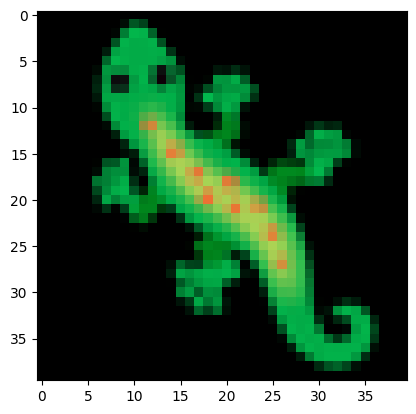

In [121]:
img_tensor = load_image(path)

# Pool Training

We want to create a pool of samples, that will contain different stages of the generation process as initial states.

In [122]:
# Samples
# | export
class SamplePool:
    def __init__(self, pool_size=1024, loss_fn=None, device=def_device):
        assert loss_fn is not None, "You need to provide a loss function"
        self.pool_size = pool_size
        self.loss_fn = loss_fn
        self.reset()

    def make_seed(self, sz=[1, CHANNEL_N, TARGET_SIZE, TARGET_SIZE]):
        seed = torch.zeros(sz).to(def_device)
        center_minus = (TARGET_SIZE - core_diameter) // 2
        center_plus = center_minus + core_diameter
        seed[:, :, center_minus:center_plus, center_minus:center_plus] = dna
        # seed[:, :, 5 : 5 + core_diameter, 5 : 5 + core_diameter] = dna
        return seed

    def reset(self):
        self.seed = self.make_seed()
        self.pool = self.seed.repeat(self.pool_size, 1, 1, 1)

    def sample(self, num_samples=8):
        # selecting a random sample from the pool
        self.idxs = torch.randperm(self.pool_size)[:num_samples]
        batch = self.pool[self.idxs, ...]

        # find the sample in the batch with the highest loss
        losses = self.loss_fn(batch[:, :COLOR_N, :, :])
        # and replace it with the seed
        # to avoid "catastrofic forgetting"
        # (i.e. forgetting how to generate the target from the seed)
        replace_idx = torch.argmax(losses).item()
        batch[replace_idx] = self.seed[0]

        return batch

    def update(self, new_samples):
        new_samples = new_samples.detach()
        # replace the old samples with the newly generated ones
        self.pool[self.idxs] = new_samples

In the SamplePool, we use a loss function to select the sample inside the batch with the highest loss and replace it with the original seed. To do so, we will use the MSE loss. 

In [123]:
# mse
#| export
def mse(pred, target, dim=1): 
    return ((pred - target) * (pred - target)).sum(dim).sum(dim=(1, 2))

In [124]:
loss_fn = partial(mse, target=img_tensor.repeat(batch_size, 1, 1, 1).to(def_device))

In [125]:
pool = SamplePool(16, loss_fn=loss_fn)
batch = pool.sample(batch_size) #TODO: fix ugly here
batch.shape

torch.Size([1, 16, 40, 40])

We also need a function that will visualize a batch of inputs to validate that the sampling of the pool works as expected.

In [126]:
def vis_batch(batch):
    B, C, H, W = batch.shape
    if C > COLOR_N:
        batch = batch[:, :COLOR_N, :, :]

    plt.figure(figsize=(16, 16))
    for i in range(B):
        plt.subplot(1, B, i + 1)
        assert type(batch) is torch.Tensor
        plt.imshow(batch[i].detach().cpu().permute(1, 2, 0).clamp(0,1))
        plt.axis('off')    

    plt.show()
#| export 

In [127]:
# print(true_target.shape)
# vis_batch(model_in)

# Training Loop

In [181]:
# Instantiate the model
# |eval: false
from NeuralCellularAutomata_PyTorch.custom_attention import (
    CustomAttention,
    Conv2DAttention,
)


# attention_n = int(CHANNEL_N ** (1 / 2) + 0.5)
# heads = int(CHANNEL_N ** (1 / 2) + 0.5)
# compress_n = int(CHANNEL_N ** (1 / 2) + 0.5)

attention_n = int(CHANNEL_N**0.5)
heads = CHANNEL_N
compress_n = CHANNEL_N

foo = CustomAttention(heads, CHANNEL_N, attention_n, compress_n)
attention = Conv2DAttention(foo)


brain = nn.Sequential(
    nn.Linear(CHANNEL_N, CHANNEL_N * 2, False),
    nn.SiLU(),
    nn.Linear(CHANNEL_N * 2, CHANNEL_N * 2, False),
    nn.SiLU(),
    # nn.Linear(32, 32, False),
    # nn.SiLU(),
    # nn.Linear(32, 32, False),
    # nn.SiLU(),
    nn.Linear(CHANNEL_N * 2, CHANNEL_N, False),
    nn.Tanh()
)

repair = CAModel(CHANNEL_N, attention, brain).to(def_device)
# embed = CAModel(CHANNEL_N, 1).to(def_device)
# repair = CAModel(CHANNEL_N, 1).to(def_device)


In [182]:
# dropout = nn.Dropout(7/8)

# full = nn.Sequential(embed,repair)

# Optimization

# ca.register_parameter("seed dna",dna)

lr = 2e-3
lr_gamma = 0.9999
betas = (0.5, 0.5)
# optimizer = torch.optim.Adam(full.parameters(), lr=lr, betas=betas)
optimizer = torch.optim.Adam(repair.parameters(), lr=lr, betas=betas)

# optimizer = torch.optim.Adam(ca.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)

augment = torchvision.transforms.RandomRotation(360)

true_target = img_tensor.repeat(batch_size, 1, 1, 1)
# foo = list(batch.shape)
# foo[1] = COLOR_N
# target = img_tensor.broadcast_to(foo)
# target = img_tensor

  0%|          | 0/8192 [00:00<?, ?it/s]

  1%|          | 63/8192 [00:05<11:12, 12.08it/s]

Epoch: 64 Loss: 0.02639690786600113 Top: 1 Bot: 0


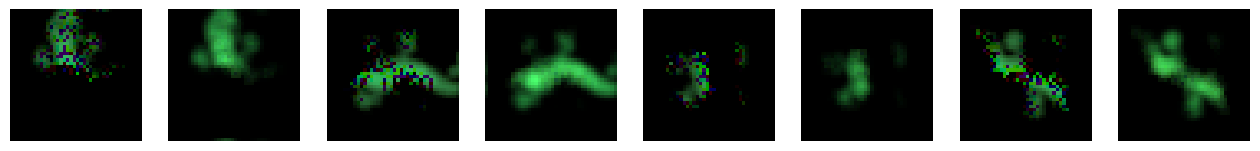

  2%|▏         | 127/8192 [00:11<11:29, 11.69it/s]

Epoch: 128 Loss: 0.018183821812272072 Top: 1 Bot: 0


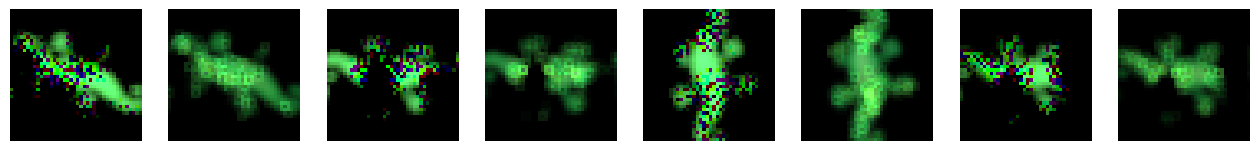

  2%|▏         | 191/8192 [00:16<10:34, 12.61it/s]

Epoch: 192 Loss: 0.030797630548477173 Top: 1 Bot: 0


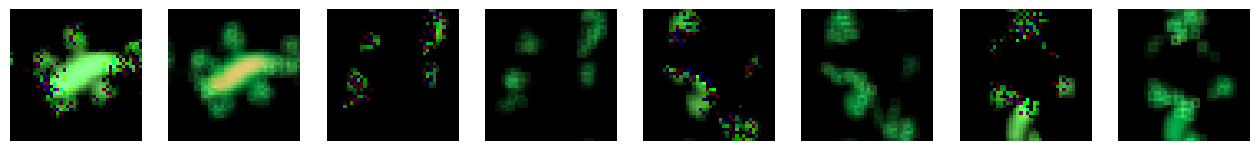

  3%|▎         | 255/8192 [00:22<11:10, 11.84it/s]

Epoch: 256 Loss: 0.03814854845404625 Top: 2 Bot: 0


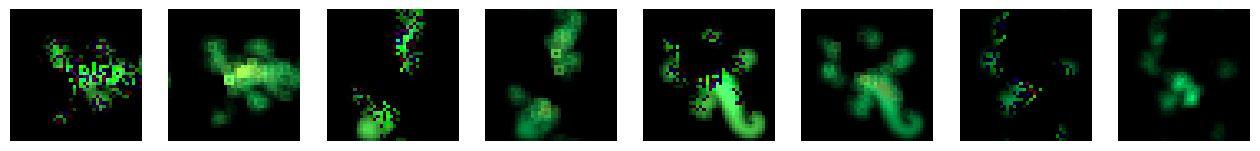

  4%|▍         | 320/8192 [00:32<18:46,  6.99it/s]

Epoch: 320 Loss: 0.01475124154239893 Top: 2 Bot: 0


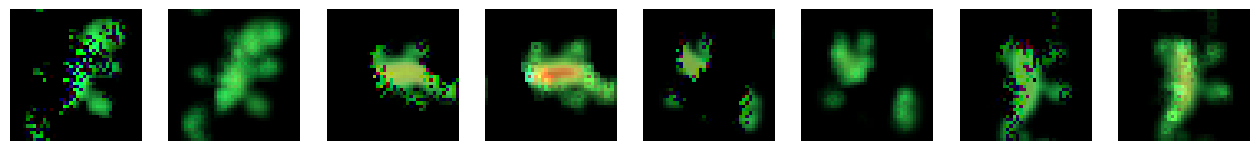

  5%|▍         | 383/8192 [00:41<16:40,  7.80it/s]

Epoch: 384 Loss: 0.014173231087625027 Top: 2 Bot: 0


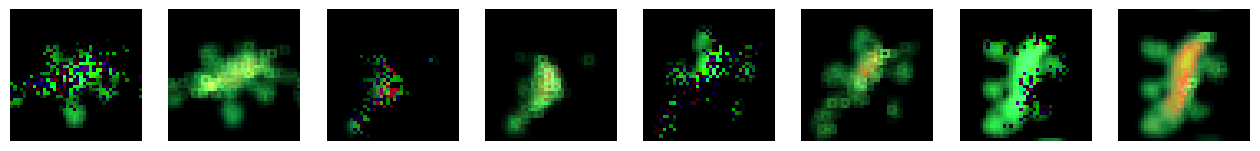

  5%|▌         | 448/8192 [00:50<26:24,  4.89it/s]

Epoch: 448 Loss: 0.020274093374609947 Top: 2 Bot: 0


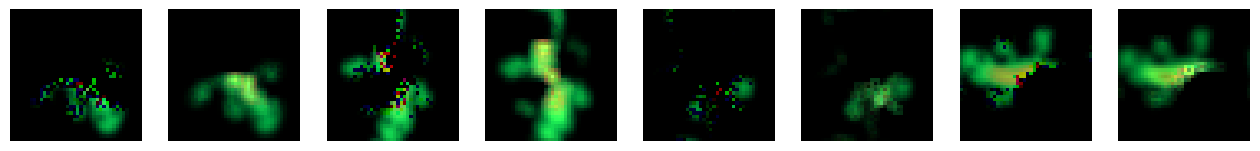

  6%|▋         | 512/8192 [01:02<23:16,  5.50it/s]

Epoch: 512 Loss: 0.011339178308844566 Top: 2 Bot: 0


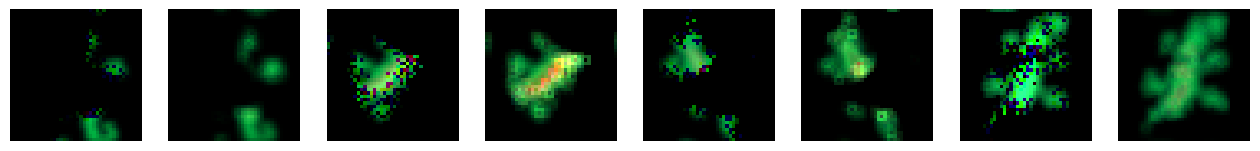

  7%|▋         | 575/8192 [01:12<21:50,  5.81it/s]

Epoch: 576 Loss: 0.010397080332040787 Top: 2 Bot: 0


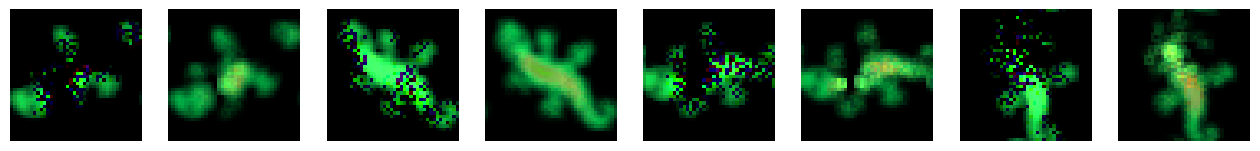

  8%|▊         | 639/8192 [01:22<20:22,  6.18it/s]

Epoch: 640 Loss: 0.03452861309051514 Top: 2 Bot: 0


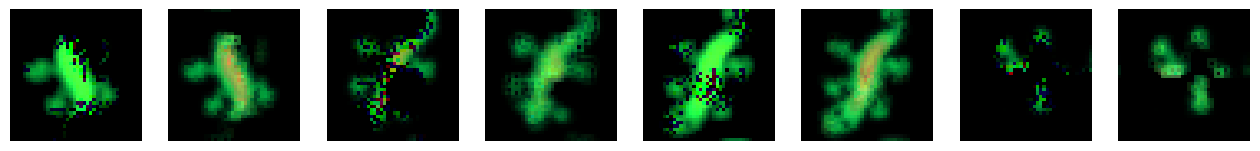

  9%|▊         | 703/8192 [01:33<21:55,  5.69it/s]

Epoch: 704 Loss: 0.007832162082195282 Top: 2 Bot: 0


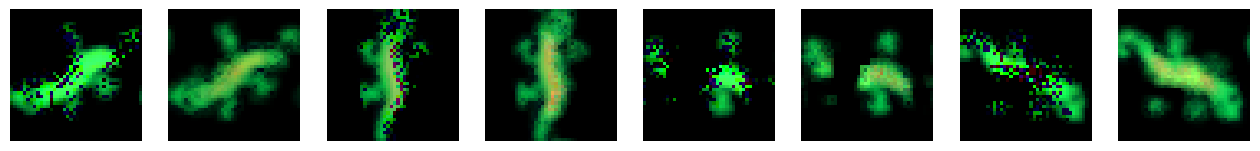

  9%|▉         | 768/8192 [01:43<15:45,  7.85it/s]

Epoch: 768 Loss: 0.02850683592259884 Top: 2 Bot: 0


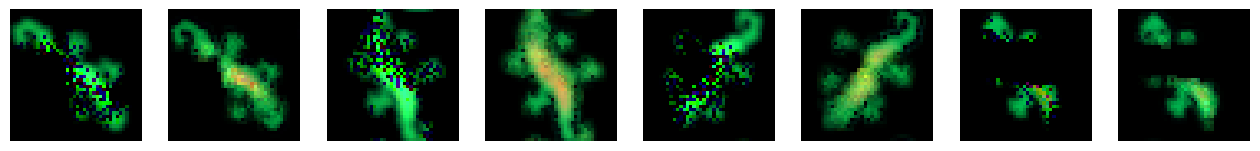

 10%|█         | 832/8192 [01:53<16:05,  7.62it/s]

Epoch: 832 Loss: 0.0050343736074864864 Top: 2 Bot: 0


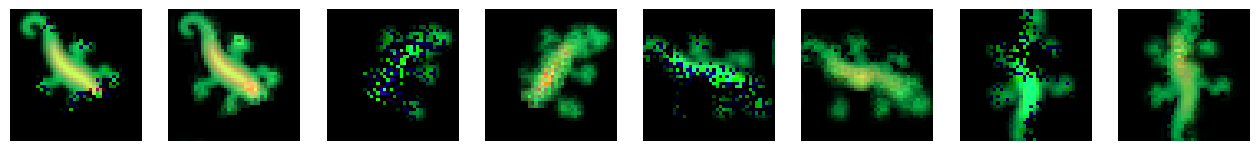

 11%|█         | 896/8192 [02:02<18:52,  6.44it/s]

Epoch: 896 Loss: 0.017693601548671722 Top: 2 Bot: 0


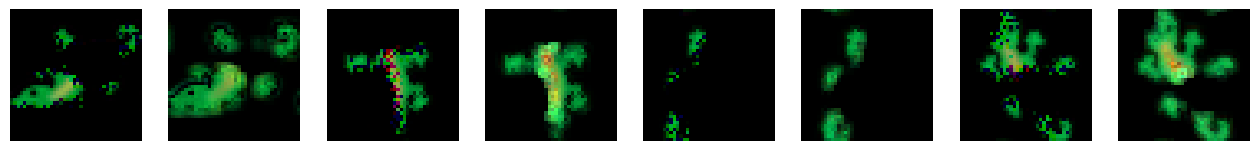

 12%|█▏        | 960/8192 [02:12<18:56,  6.36it/s]

Epoch: 960 Loss: 0.008807456120848656 Top: 2 Bot: 0


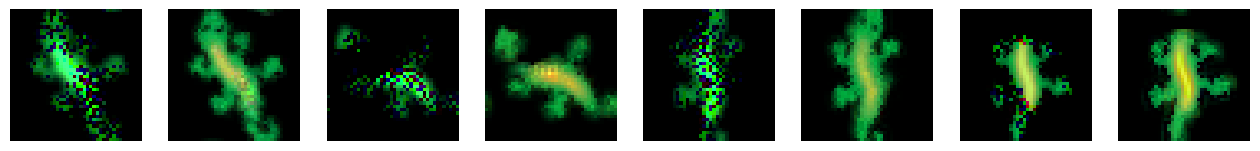

 12%|█▎        | 1024/8192 [02:22<17:29,  6.83it/s]

Epoch: 1024 Loss: 0.011288915760815144 Top: 3 Bot: 0


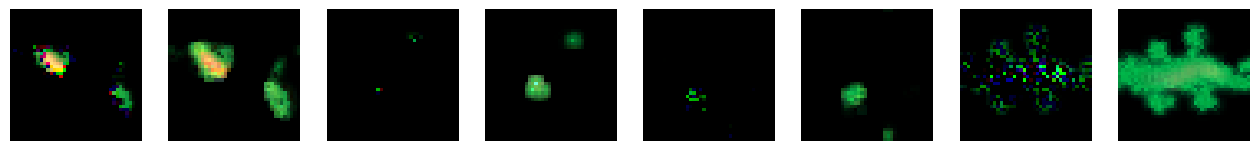

 13%|█▎        | 1088/8192 [02:36<27:31,  4.30it/s]

Epoch: 1088 Loss: 0.00912550836801529 Top: 3 Bot: 0


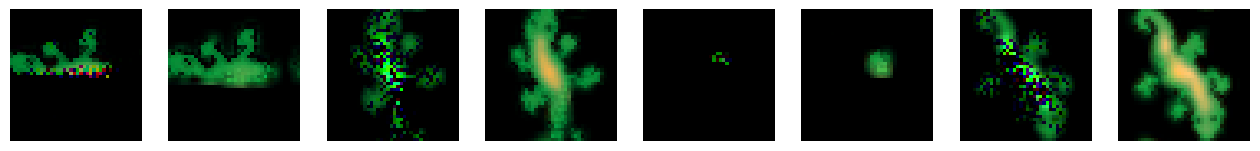

 14%|█▍        | 1152/8192 [02:49<33:57,  3.46it/s]

Epoch: 1152 Loss: 0.041402459144592285 Top: 3 Bot: 0


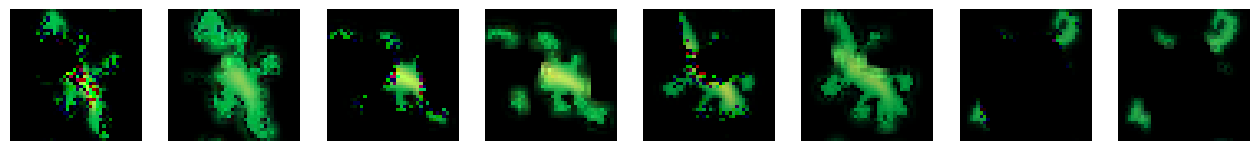

 15%|█▍        | 1216/8192 [03:01<23:41,  4.91it/s]

Epoch: 1216 Loss: 0.019647734239697456 Top: 3 Bot: 0


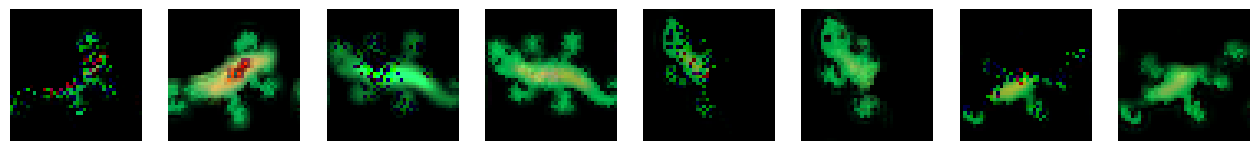

 16%|█▌        | 1280/8192 [03:15<23:34,  4.89it/s]

Epoch: 1280 Loss: 0.00780012272298336 Top: 3 Bot: 0


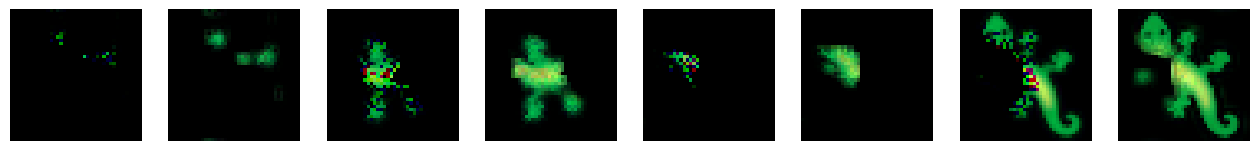

 16%|█▋        | 1344/8192 [03:27<20:10,  5.66it/s]

Epoch: 1344 Loss: 0.004490447696298361 Top: 3 Bot: 0


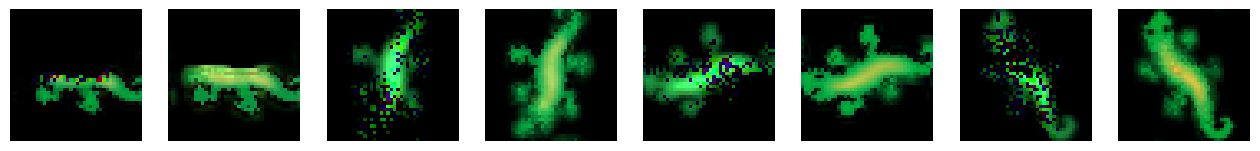

 17%|█▋        | 1408/8192 [03:41<21:11,  5.33it/s]

Epoch: 1408 Loss: 0.043845415115356445 Top: 3 Bot: 0


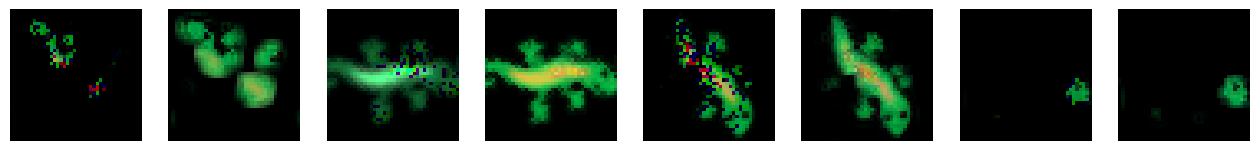

 18%|█▊        | 1472/8192 [03:54<34:11,  3.28it/s]

Epoch: 1472 Loss: 0.01681387424468994 Top: 3 Bot: 0


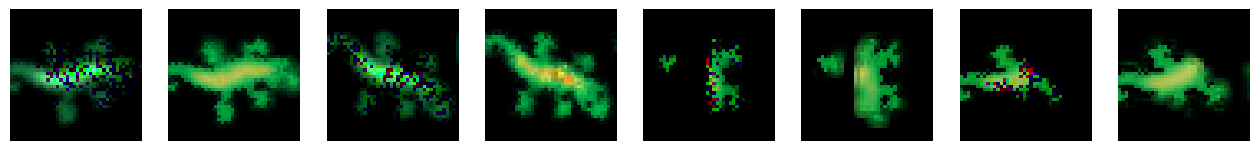

 19%|█▉        | 1536/8192 [04:07<20:04,  5.53it/s]

Epoch: 1536 Loss: 0.0053803082555532455 Top: 3 Bot: 0


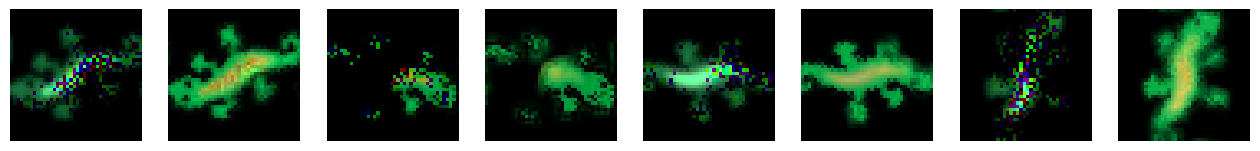

 20%|█▉        | 1600/8192 [04:21<28:50,  3.81it/s]

Epoch: 1600 Loss: 0.002270611235871911 Top: 3 Bot: 0


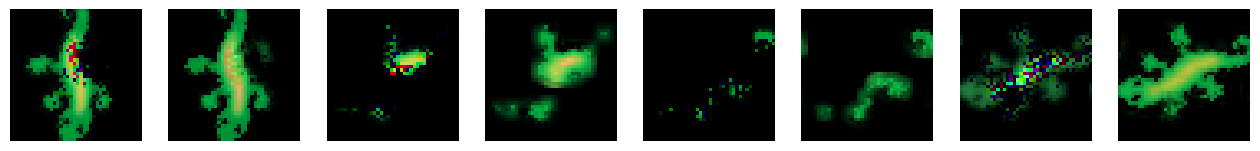

 20%|██        | 1664/8192 [04:39<31:41,  3.43it/s]

Epoch: 1664 Loss: 0.02199867181479931 Top: 3 Bot: 0


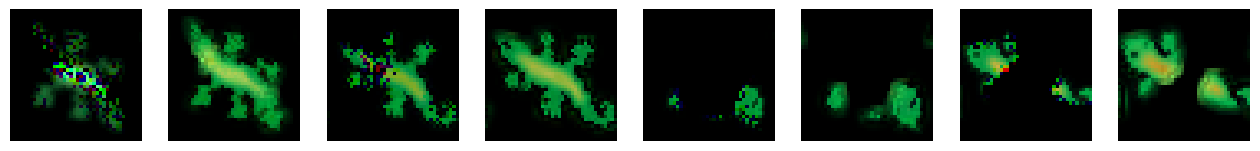

 21%|██        | 1728/8192 [04:54<21:14,  5.07it/s]

Epoch: 1728 Loss: 0.003176154335960746 Top: 3 Bot: 0


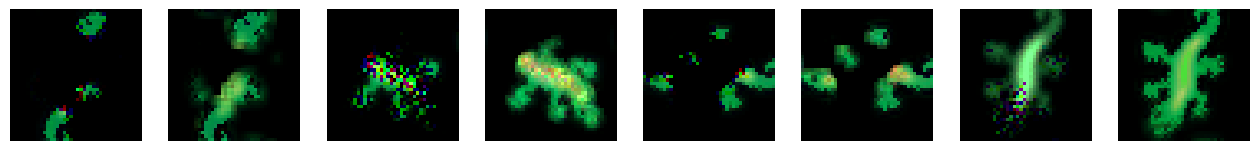

 22%|██▏       | 1778/8192 [05:04<18:17,  5.84it/s]


KeyboardInterrupt: 

In [ ]:
# run the training
# |eval: false

import math


chunk = 2**8
chunk_num = 32
n_epochs = chunk * chunk_num
drop_scale = 4

peek_interval = chunk / 4

# print(chunk)

# priority = 0.5

model_in = torch.zeros_like(pool.sample(batch_size))


class Logger:
    def __init__(self) -> None:
        self.l = []

    def i(self, it):
        self.l.append(it)

    def o(self, a):
        out = []
        for i in a:
            out.append(self.l[i])
        out = torch.cat(out)
        self.l.clear()
        return out


def noise_mask(res, scale, range):
    return F.interpolate(
        torch.rand_like(res[:, :range, :scale, :scale]),
        res.shape[2:],
        mode="bilinear",
        # torch.rand_like(res[:, :, :scale, :scale]), res.shape[2:], mode="bilinear"
    )


def soft_mask(noise, slope, ceil):
    if slope <= 0:
        slope = math.inf
    mask = slope * (noise - ceil) + 1
    return mask.clamp(0, 1)


def hard_mask(noise, cutoff):
    mask = (noise + cutoff).floor()
    return mask.clamp(0, 1)


log: Logger = Logger()

for i in tqdm(range(n_epochs)):
    # zero the optimizer
    optimizer.zero_grad()

    # set the number of steps to take
    top = 1
    bot = 0
    top += int(((i) / (n_epochs)) ** 0.5 * chunk_num)
    # bot += i // (chunk * 1)
    # top += 8
    # bot += 7
    # steps = torch.randint(bot, top, (1,)).item()
    # steps += 1

    if top == 0:
        top = 1

    # model_in = true_target

    # model_in = torch.zeros_like(pool.sample(batch_size))
    model_in[:, :COLOR_N] = true_target[:, :COLOR_N]
    model_in[:, :COLOR_N] = augment(true_target)[:, :COLOR_N]
    res = model_in
    # log.i(res)

    steps = torch.randint(bot, top, (1,)).item()
    steps += 1
    res = repair(res, steps=steps)
    # log.i(res)

    loss = torch.zeros(1)

    # loss += F.mse_loss(res[:, :COLOR_N], model_in[:, :COLOR_N]) * priority

    # res = dropout(res, torch.rand((1,)).item() ** 0.5)

    pos = steps / (top + 1)
    ceil = 0.75

    res = res * hard_mask(
        soft_mask(noise_mask(res, drop_scale, 1), (1 / ceil) / (1 - pos), ceil),
        noise_mask(res, TARGET_SIZE, CHANNEL_N),
    )
    log.i(res)

    steps = torch.randint(bot, top, (1,)).item()
    steps += 1
    res = repair(res, steps=steps)

    loss += F.mse_loss(res[:, :COLOR_N], model_in[:, :COLOR_N])
    log.i(res)

    if i % (peek_interval) == 0 and i != 0:
        print(f"Epoch: {i} Loss: {loss.item()} Top: {top} Bot: {bot}")
        vis_batch(
            log.o(
                range(-8, 0),
            )
        )

    # assert math.isfinite(loss.item()), "Explosion"
    if not math.isfinite(loss.item()):
        print("Explosion")

    # backpropagate the loss and update the weights
    loss.backward()
    optimizer.step()
    scheduler.step()

In [ ]:
torch.set_printoptions(profile="full")
print(repair.state_dict())
torch.set_printoptions(profile="default")
# # import save1
# # ca.load_state_dict(save1.getSave())


In [ ]:
# torch.save(repair.state_dict(),"save1.pt") # TAKEN


In [168]:
# |eval: false

# assert type(embed) is CAModel
# assert type(repair.grow_animation) is function

rot = augment(model_in)

images = repair.grow_animation(rot,64)
# display_animation(images)

# images = images + repair.grow_animation(dropout(repair(rot,16),0.5), 16)

for i in range(0,len(images)):
    # print(images[i].shape)
    images[i] = images[i][...,:COLOR_N]

display_animation(images)

The automato manages to maintain it's shape as time passes. 

### Visualize a batch from the updated pool. 

During the training process we update the samples inside the pool. 
Let's visualize how a sample would look like after the training process is completed. 

In [ ]:
#| eval: false
batch = pool.sample(batch_size)
#| eval: false
vis_batch(batch)